In [1]:
# this script analyzes inundation extents and relates them to water levels at Koh Khel 

# source of inundation extents: 
# https://code.earthengine.google.com/5ea04d1904acc7e882f322a4ed791012
# https://code.earthengine.google.com/e2ac46825dc1427a0871278ff5cf2f7b


In [2]:
# import necessary packages
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import datetime
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import math
from matplotlib.dates import date2num

In [3]:
# standardise water level data at Koh Kehl 

## import, convert datetime, drop unnecessary columns
wl_long = pd.read_csv('wl_KK.csv')
wl_long['date'] = pd.to_datetime(wl_long['date'])
wl_long['date'] = wl_long['date'].dt.strftime('%Y-%m-%d')
wl_long.columns = ['huh', 'date', 'wl_long']
wl_long = wl_long.drop(columns=['huh'])
wl_long = wl_long.set_index('date')
wl_long['wl_long'] = wl_long['wl_long']-1 # <------ -1 correct for elevation 

# standardise to daily 
wl_long.index = pd.to_datetime(wl_long.index)
wl_long1 = wl_long.resample('d').mean()
wl_KK_daily = wl_long1  
wl_KK_daily.columns = ['wl_KK']

# calculate rolling mean of 3 days 
wl_KK_daily = wl_KK_daily.rolling(center=False, window=3, min_periods=1).mean().round(2)

wl_KK_daily.tail()

,wl_KK
date,
2021-03-18,1.01
2021-03-19,1.00
2021-03-20,0.99
2021-03-21,0.97
2021-03-22,0.97


In [4]:
###############################################################################
#
# Zone 2C
#
###############################################################################

In [5]:
# Zone 2C

opticalfilename = 'Landsat_Flooded_Areas_2C.csv'  

## optical data 

op =pd.read_csv(opticalfilename)

op['date'] = pd.to_datetime(op['date'])
op['date'] = op['date'].dt.strftime('%Y-%m-%d')

#minimum_area = op['totalarea'].max()*0.95

#op = op[op['totalarea'] > minimum_area]

op['flooded'] = 100*(op['flood']/op['totalarea'])
op = op.drop(columns=['system:index', 'dry', 'flood', 'totalarea', '.geo'])
op = op.set_index('date')
op.columns = ['flood_optical']

flood = op.merge(wl_KK_daily, how="left", left_index=True, right_index=True)
flood.to_csv('Landsat_Link_2C.csv')

flood.head()



,flood_optical,wl_KK
date,,
1991-11-29,41.096138,4.47
1992-03-20,6.204682,1.05
1993-11-02,19.875984,5.00
1994-11-05,33.016370,5.26
1994-11-21,23.740931,4.28


In [6]:

flood = op.merge(wl_KK_daily, how="outer", left_index=True, right_index=True)
flood['date'] = flood.index
flood = flood[(flood['date']>'1991-01-01')]
flood.head()

,flood_optical,wl_KK,date
date,,,
1991-01-02,NaN,3.43,1991-01-02
1991-01-03,NaN,3.30,1991-01-03
1991-01-04,NaN,3.27,1991-01-04
1991-01-05,NaN,3.24,1991-01-05
1991-01-06,NaN,3.19,1991-01-06


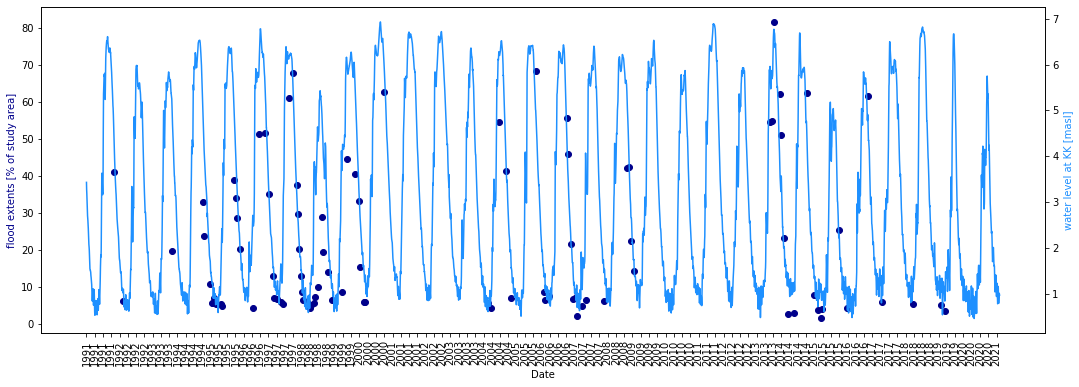

In [7]:
# visualise: 

# Initialise the figure and axes.

fig, ax1 = plt.subplots(1, figsize=(18, 6))

# Set the title for the figure
#fig.suptitle('shifted 23 days', fontsize=15)


# define axes 
y1 = flood['flood_optical']
y2 = flood['wl_KK']

#x = flood_daily.index
x = date2num(pd.to_datetime(flood.index))

ax2 = ax1.twinx()
ax1.scatter(x, y1, color="darkblue", label="flood extents")
ax2.plot(x, y2, color="dodgerblue", label="water level at KK")

#plt.legend(loc="upper left", title="Legend ", frameon=False)
#ax2.legend(loc=0)
#ax1.legend(loc=1)

#plt.xticks(rotation = 45)

ax1.set_xlabel('Date')
ax1.set_ylabel('flood extents [% of study area]', color='darkblue')
ax2.set_ylabel('water level at KK [masl]', color='dodgerblue')


axes = plt.gca()
ax1.xaxis_date()
myFmt = mdates.DateFormatter('%Y')

ax1.xaxis.set_major_formatter(myFmt)

plt.xticks(np.arange(min(x), max(x), 100.0))


plt.setp( ax1.xaxis.get_majorticklabels(), rotation=90 )

fig.savefig('Landsat_KK_Relation_2C', dpi=300)


plt.show()

In [8]:
#### correlate with inundation extents! 
inun = pd.read_csv('inundation_link_Sentinel_Zone2C.csv')
inun = inun.set_index('wl_KK')

flood = flood.set_index('wl_KK')

flood_link = inun.merge(flood, how='outer', left_index=True, right_index=True)

flood_link = flood_link.sort_values('date')

flood_link['wl_KK'] = flood_link.index
flood_link.head()

,freq_overall,freq_Jul15,freq_Jul31,freq_Aug15,freq_Aug31,freq_Sep25,Minimum,Maximum,overall,90s,...,pre08,post08,freq_Dec1,freq_Dec15,freq_Jan1,area,cumulative_area,flood_optical,date,wl_KK
wl_KK,,,,,,,,,,,,,,,,,,,,,
3.43,0.92,0.406667,0.406667,0.513333,0.67,0.873333,38.333333,38.333333,148.020000,163.633333,...,162.613333,126.140000,0.67,0.500000,0.223333,71275.000000,749166.000000,NaN,1991-01-02,3.43
3.30,0.92,0.461569,0.461569,0.620000,0.77,0.920000,39.686275,39.686275,152.740784,168.219608,...,167.610000,130.430196,0.67,0.503333,0.330000,78384.058824,651907.215686,NaN,1991-01-03,3.30
3.27,0.92,0.474118,0.474118,0.620000,0.77,0.920000,40.176471,40.176471,153.617059,169.276471,...,168.600000,131.131765,0.67,0.530000,0.330000,80439.529412,614792.941176,NaN,1991-01-04,3.27
3.24,0.92,0.488235,0.488235,0.620000,0.77,0.920000,40.352941,40.352941,154.464118,170.352941,...,169.590000,131.763529,0.67,0.560000,0.330000,79783.058824,600481.882353,NaN,1991-01-05,3.24
3.19,0.92,0.511765,0.511765,0.620000,0.77,0.920000,40.647059,40.647059,155.875882,172.147059,...,171.240000,132.816471,0.67,0.610000,0.330000,78688.941176,576630.117647,NaN,1991-01-06,3.19


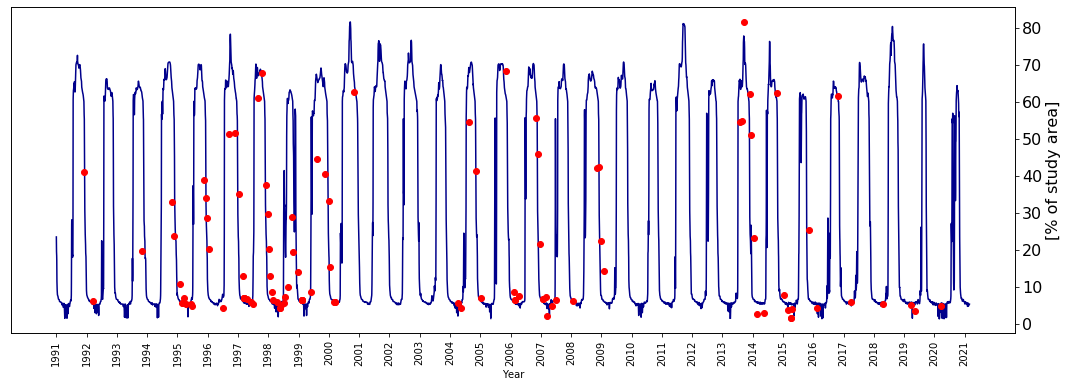

In [9]:
# visualise: 

# Initialise the figure and axes.

fig, ax1 = plt.subplots(1, figsize=(18, 6))

SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIGGER_SIZE = 16

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


# Set the title for the figure
#fig.suptitle('Zone B: Inundation extents according to Landsat images and Sentinel- based flood link', fontsize=15)



# define axes 
y1 = flood_link['cumulative_area']
y2 = flood_link['flood_optical']

#x = flood_daily.index
x = date2num(pd.to_datetime(flood_link['date']))

ax2 = ax1.twinx()
ax1.plot(x, y1, color="darkblue", label="calculated inundation extents")
ax2.scatter(x, y2, color="red", label="Landsat inundation extents")

#plt.legend(loc="upper left", title="Legend ", frameon=False)
#ax2.legend(loc=0)
#ax1.legend(loc=1)

#plt.xticks(rotation = 45)

ax1.set_xlabel('Year')
#ax2.legend(bbox_to_anchor =(0.3, 1.23), title="Legend ", frameon=False)
ax2.set_ylabel('[% of study area]')
#ax1.legend(bbox_to_anchor =(0.3, 1.1), frameon=False)


axes = plt.gca()
ax1.xaxis_date()
myFmt = mdates.DateFormatter('%Y')

ax1.xaxis.set_major_formatter(myFmt)

plt.xticks(np.arange(min(x), max(x),366.0))
ax1.axes.yaxis.set_visible(False)


plt.setp( ax1.xaxis.get_majorticklabels(), rotation=90 )

fig.savefig('Landsat_Sentinel_FloodExtent_Relation_ZoneB', dpi=300, bbox_inches = "tight")


plt.show()

In [11]:
flood_link.head()

,freq_overall,freq_Jul15,freq_Jul31,freq_Aug15,freq_Aug31,freq_Sep25,Minimum,Maximum,overall,90s,...,pre08,post08,freq_Dec1,freq_Dec15,freq_Jan1,area,cumulative_area,flood_optical,date,wl_KK
wl_KK,,,,,,,,,,,,,,,,,,,,,
3.43,0.92,0.406667,0.406667,0.513333,0.67,0.873333,38.333333,38.333333,148.020000,163.633333,...,162.613333,126.140000,0.67,0.500000,0.223333,71275.000000,749166.000000,NaN,1991-01-02,3.43
3.30,0.92,0.461569,0.461569,0.620000,0.77,0.920000,39.686275,39.686275,152.740784,168.219608,...,167.610000,130.430196,0.67,0.503333,0.330000,78384.058824,651907.215686,NaN,1991-01-03,3.30
3.27,0.92,0.474118,0.474118,0.620000,0.77,0.920000,40.176471,40.176471,153.617059,169.276471,...,168.600000,131.131765,0.67,0.530000,0.330000,80439.529412,614792.941176,NaN,1991-01-04,3.27
3.24,0.92,0.488235,0.488235,0.620000,0.77,0.920000,40.352941,40.352941,154.464118,170.352941,...,169.590000,131.763529,0.67,0.560000,0.330000,79783.058824,600481.882353,NaN,1991-01-05,3.24
3.19,0.92,0.511765,0.511765,0.620000,0.77,0.920000,40.647059,40.647059,155.875882,172.147059,...,171.240000,132.816471,0.67,0.610000,0.330000,78688.941176,576630.117647,NaN,1991-01-06,3.19


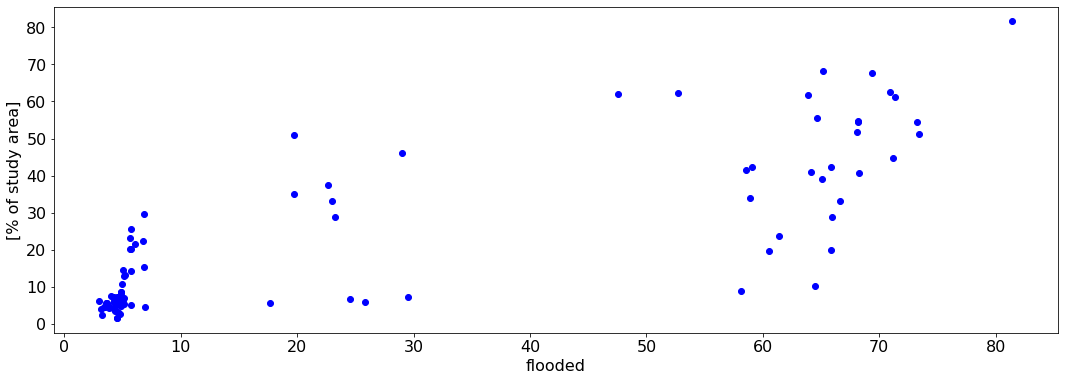

In [15]:

fig, ax = plt.subplots(1, figsize=(18, 6))

# define axes 

optical_max = flood_link['flood_optical'].max()

flood_link['flood_optical_perc'] = (flood_link['flood_optical']/optical_max)*100

cum_area_max = flood_link['cumulative_area'].max()

flood_link['cumulative_area_perc'] = (flood_link['cumulative_area']/cum_area_max)*100

y1 = flood_link['flood_optical_perc']

#x = flood_daily.index
x = flood_link['cumulative_area_perc']


ax.scatter(x, y2, color="blue", label="Landsat inundation extents")


ax.set_xlabel('flooded')
ax.set_ylabel('[% of study area]')

#fig.savefig('Landsat_Sentinel_FloodExtent_Relation_ZoneB', dpi=300, bbox_inches = "tight")


plt.show()

In [16]:
###############################################################################
#
# Prek Area 
#
###############################################################################

In [17]:
# Prek Area

opticalfilename = 'Landsat_Flooded_Areas_PA.csv'  

## optical data 

op =pd.read_csv(opticalfilename)

op['date'] = pd.to_datetime(op['date'])
op['date'] = op['date'].dt.strftime('%Y-%m-%d')


#minimum_area = op['totalarea'].max()*0.95

#op = op[op['totalarea'] > minimum_area]

op['flooded'] = 100*(op['flood']/op['totalarea'])
op = op.drop(columns=['system:index', 'dry', 'flood', 'totalarea', '.geo'])
op = op.set_index('date')
op.columns = ['flood_optical']

flood = op.merge(wl_KK_daily, how="inner", left_index=True, right_index=True)
flood.to_csv('Landsat_Link_PA.csv')
flood = op.merge(wl_KK_daily, how="outer", left_index=True, right_index=True)
flood['date'] = flood.index
flood = flood[(flood['date']>'1991-01-01')]
flood.head()




,flood_optical,wl_KK,date
date,,,
1991-01-02,NaN,3.43,1991-01-02
1991-01-03,NaN,3.30,1991-01-03
1991-01-04,NaN,3.27,1991-01-04
1991-01-05,NaN,3.24,1991-01-05
1991-01-06,NaN,3.19,1991-01-06


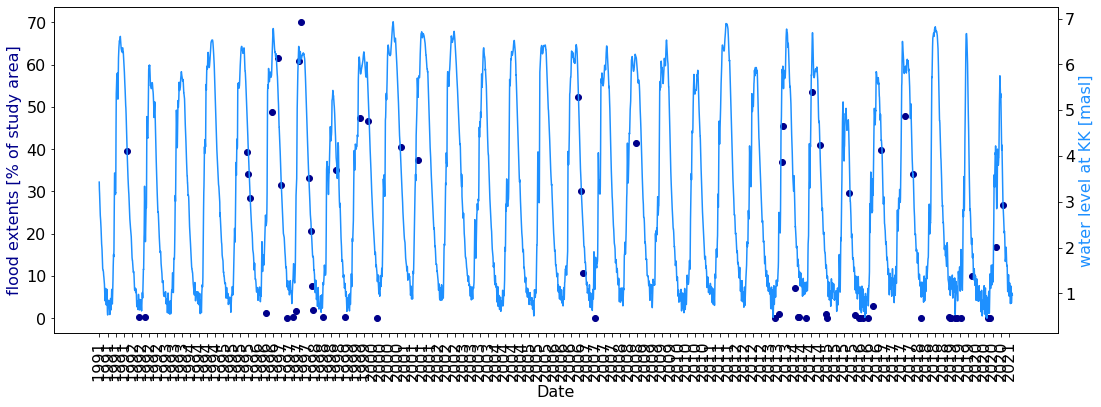

In [18]:
# visualise: 

# Initialise the figure and axes.

fig, ax1 = plt.subplots(1, figsize=(18, 6))

# Set the title for the figure
#fig.suptitle('shifted 23 days', fontsize=15)


# define axes 
y1 = flood['flood_optical']
y2 = flood['wl_KK']

#x = flood_daily.index
x = date2num(pd.to_datetime(flood.index))

ax2 = ax1.twinx()
ax1.scatter(x, y1, color="darkblue", label="flood extents")
ax2.plot(x, y2, color="dodgerblue", label="water level at KK")

#plt.legend(loc="upper left", title="Legend ", frameon=False)
#ax2.legend(loc=0)
#ax1.legend(loc=1)

#plt.xticks(rotation = 45)

ax1.set_xlabel('Date')
ax1.set_ylabel('flood extents [% of study area]', color='darkblue')
ax2.set_ylabel('water level at KK [masl]', color='dodgerblue')


axes = plt.gca()
ax1.xaxis_date()
myFmt = mdates.DateFormatter('%Y')

ax1.xaxis.set_major_formatter(myFmt)

plt.xticks(np.arange(min(x), max(x), 100.0))


plt.setp( ax1.xaxis.get_majorticklabels(), rotation=90 )

fig.savefig('Landsat_KK_Relation_2C', dpi=300)


plt.show()

In [19]:
#### correlate with inundation extents! 
inun = pd.read_csv('inundation_link_Sentinel_PA.csv')
inun = inun.set_index('wl_KK')

flood = flood.set_index('wl_KK')

flood_link = inun.merge(flood, how='outer', left_index=True, right_index=True)

flood_link = flood_link.sort_values('date')

flood_link['wl_KK'] = flood_link.index
flood_link.head()

,area,cumulative_area,flood_optical,date,wl_KK
wl_KK,,,,,
3.43,40718.454545,389322.909091,NaN,1991-01-02,3.43
3.30,39417.666667,380474.833333,NaN,1991-01-03,3.30
3.27,39117.484848,378432.969697,NaN,1991-01-04,3.27
3.24,38817.303030,376391.106061,NaN,1991-01-05,3.24
3.19,38155.409091,371086.151515,NaN,1991-01-06,3.19


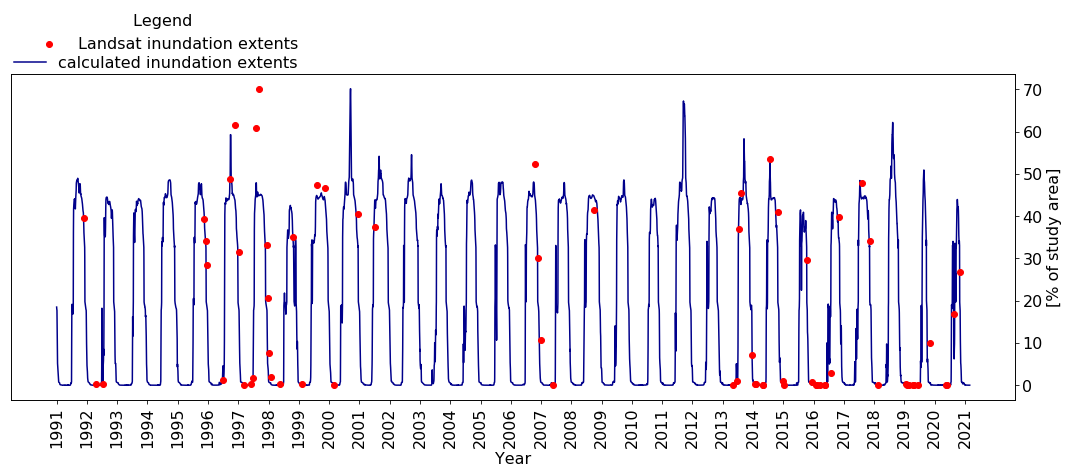

In [20]:
# visualise: 

# Initialise the figure and axes.

fig, ax1 = plt.subplots(1, figsize=(18, 6))


SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIGGER_SIZE = 16

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


# Set the title for the figure
#fig.suptitle('Inundation extents according to Landsat images and Sentinel- based flood link (Prek Area)  ', fontsize=15)


# define axes 
y1 = flood_link['cumulative_area']
y2 = flood_link['flood_optical']

#x = flood_daily.index
x = date2num(pd.to_datetime(flood_link['date']))

ax2 = ax1.twinx()
ax1.plot(x, y1, color="darkblue", label="calculated inundation extents")
ax2.scatter(x, y2, color="red", label="Landsat inundation extents")

#plt.legend(loc="upper left", title="Legend ", frameon=False)
ax2.legend(bbox_to_anchor =(0.19, 0.95), title="Legend ", frameon=False)
ax1.legend(bbox_to_anchor =(0.19, 0.85), frameon=False)

#plt.xticks(rotation = 45)

ax1.set_xlabel('Year')
ax2.legend(bbox_to_anchor =(0.3, 1.23), title="Legend ", frameon=False)
ax2.set_ylabel('[% of study area]')
ax1.legend(bbox_to_anchor =(0.3, 1.1), frameon=False)


axes = plt.gca()
ax1.xaxis_date()
myFmt = mdates.DateFormatter('%Y')

ax1.xaxis.set_major_formatter(myFmt)

plt.xticks(np.arange(min(x), max(x), 366.0))
ax1.axes.yaxis.set_visible(False)

plt.setp( ax1.xaxis.get_majorticklabels(), rotation=90 )

fig.savefig('Landsat_Sentinel_FloodExtent_Relation_ZoneA', dpi=300, bbox_inches = "tight")


plt.show()

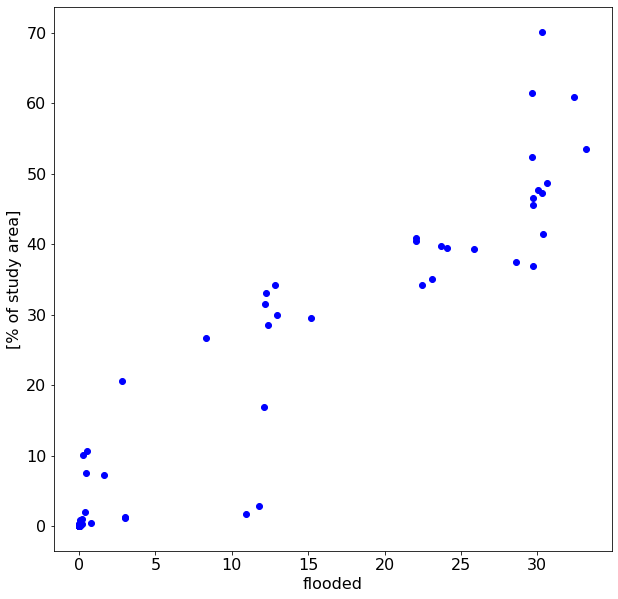

In [22]:

fig, ax = plt.subplots(1, figsize=(10, 10))

# define axes 

optical_max = flood_link['flood_optical'].max()

flood_link['flood_optical_perc'] = (flood_link['flood_optical']/optical_max)*100

cum_area_max = flood_link['cumulative_area'].max()

flood_link['cumulative_area_perc'] = (flood_link['cumulative_area']/cum_area_max)*100

y1 = flood_link['flood_optical_perc']

#x = flood_daily.index
x = flood_link['cumulative_area_perc']


ax.scatter(x, y2, color="blue", label="Landsat inundation extents")


ax.set_xlabel('flooded')
ax.set_ylabel('[% of study area]')

#fig.savefig('Landsat_Sentinel_FloodExtent_Relation_ZoneB', dpi=300, bbox_inches = "tight")


plt.show()

In [14]:
######## comparison with flooded extents for TanDEM-X 

elevations = pd.read_csv('inundation_link_tandem_Z2C.csv')

elevations.columns = ['wl_KK', 'area', 'cumarea', 'cumarea_percent_TD']
elevations = elevations.set_index('wl_KK')

wl_series = wl_KK_daily

wl_series['date'] = wl_series.index

wl_series = wl_series.set_index('wl_KK')

flood_link = elevations.merge(wl_series, how='inner', left_index=True, right_index=True)

flood_link = flood_link.merge(inun, how='inner', left_index=True, right_index=True)

flood_link = flood_link[(flood_link['date']>'1990-12-31')]

flood_link_max_s = flood_link['cumulative_area'].max()
flood_link_max_td = flood_link['cumarea'].max()

flood_link['sentinel'] = flood_link['cumulative_area']/flood_link_max_s*100
flood_link['tandem'] = flood_link['cumarea']/flood_link_max_td*100

flood_link = flood_link.set_index('date')

flood_link = flood_link.sort_index()

flood_link.head()

FileNotFoundError: [Errno 2] File inundation_link_tandem_Z2C.csv does not exist: 'inundation_link_tandem_Z2C.csv'

In [ ]:
# visualise: 

# Initialise the figure and axes.

fig, ax1 = plt.subplots(1, figsize=(18, 6))

# Set the title for the figure
fig.suptitle('Comparison of inundation extents based on TandDEM and Sentinel- based flood link (Prek Area)  ', fontsize=15)


# define axes 
y1 = flood_link['sentinel']
y2 = flood_link['tandem']

#x = flood_daily.index
x = date2num(pd.to_datetime(flood_link.index))

ax2 = ax1.twinx()
ax1.plot(x, y1, color="darkblue", label="flood extents")
ax2.plot(x, y2, color="turquoise", label="water level at KK")

#plt.legend(loc="upper left", title="Legend ", frameon=False)
#ax2.legend(loc=0)
#ax1.legend(loc=1)

#plt.xticks(rotation = 45)

ax1.set_xlabel('Year')
ax1.set_ylabel('Flood extents [% of study area]', color='darkblue')
#ax2.set_ylabel('Flood extents based on TanDEM-X [% of max]', color='turquoise')


axes = plt.gca()
ax1.xaxis_date()
myFmt = mdates.DateFormatter('%Y')

ax1.xaxis.set_major_formatter(myFmt)

plt.xticks(np.arange(min(x), max(x), 200.0))


plt.setp( ax1.xaxis.get_majorticklabels(), rotation=90 )

fig.savefig('Sentinel_FloodExtent_Tandem_ZoneB', dpi=300)


plt.show()